# Modeling and Simulation in Python

Chapter 23

Copyright 2017 Allen Downey

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)


In [1]:
# Configure Jupyter so figures appear in the notebook
%matplotlib inline

# Configure Jupyter to display the assigned value after an assignment
%config InteractiveShell.ast_node_interactivity='last_expr_or_assign'

# import functions from the modsim.py module
from modsim import *

### Code from the previous chapter

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree

<Unit('degree')>

In [3]:
t_end = 20 * s
dt = t_end / 100

params = Params(x = 0 * m, 
                y = 1 * m,
                g = 9.8 * m/s**2,
                mass = 145e-3 * kg,
                diameter = 73e-3 * m,
                rho = 1.2 * kg/m**3,
                C_d = 0.3,
                angle = 45 * degree,
                velocity = 40 * m / s,
                t_end=t_end,
                dt=dt)

,values
x,0 meter
y,1 meter
g,9.8 meter / second ** 2
mass,0.145 kilogram
diameter,0.073 meter
rho,1.2 kilogram / meter ** 3
C_d,0.3
angle,45 degree
velocity,40.0 meter / second
t_end,20 second


In [4]:
def make_system(params):
    """Make a system object.
    
    params: Params object with angle, velocity, x, y,
               diameter, duration, g, mass, rho, and C_d
               
    returns: System object
    """
    angle, velocity = params.angle, params.velocity
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    R = Vector(params.x, params.y)
    V = Vector(vx, vy)
    init = State(R=R, V=V)
    
    # compute area from diameter
    diameter = params.diameter
    area = np.pi * (diameter/2)**2
    
    return System(params, init=init, area=area)

In [5]:
def drag_force(V, system):
    """Computes drag force in the opposite direction of `V`.
    
    V: velocity Vector
    system: System object with rho, C_d, area
    
    returns: Vector drag force
    """
    rho, C_d, area = system.rho, system.C_d, system.area
    
    mag = rho * V.mag**2 * C_d * area / 2
    direction = -V.hat()
    f_drag = direction * mag
    return f_drag

In [6]:
def slope_func(state, t, system):
    """Computes derivatives of the state variables.
    
    state: State (x, y, x velocity, y velocity)
    t: time
    system: System object with g, rho, C_d, area, mass
    
    returns: sequence (vx, vy, ax, ay)
    """
    R, V = state
    mass, g = system.mass, system.g
    
    a_drag = drag_force(V, system) / mass
    a_grav = Vector(0, -g)
    
    A = a_grav + a_drag
    
    return V, A

In [7]:
def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    R, V = state
    return R.y

### Optimal launch angle

To find the launch angle that maximizes distance from home plate, we need a function that takes launch angle and returns range.

In [8]:
def range_func(angle, params):  
    """Computes range for a given launch angle.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: distance in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    results, details = run_ode_solver(system, slope_func, events=event_func)
    x_dist = get_last_value(results.R).x
    print(angle, x_dist)
    return x_dist

Let's test `range_func`.

In [9]:
range_func(45, params)

45 102.67621633303261 meter


102.67621633303261 <Unit('meter')>

And sweep through a range of angles.

In [10]:
angles = linspace(20, 80, 21)
sweep = SweepSeries()

for angle in angles:
    x_dist = range_func(angle, params)
    sweep[angle] = x_dist

20.0 79.83369234082717 meter
23.0 86.20478395495141 meter
26.0 91.4709452133534 meter
29.0 95.83255039259141 meter
32.0 99.10671362732461 meter
35.0 101.51073514079798 meter
38.0 102.9023803583573 meter
41.0 103.40314791198459 meter
44.0 103.02100653301224 meter
47.0 101.73693469942923 meter
50.0 99.56858789440345 meter
53.0 96.55360348120037 meter
56.0 92.7050051463521 meter
59.0 88.04022482508677 meter
62.0 82.58080180144869 meter
65.0 76.32548350395584 meter
68.0 69.32998156572299 meter
71.0 61.63270335890529 meter
74.0 53.24654950607608 meter
77.0 44.252471292784826 meter
80.0 34.68860100116735 meter


Plotting the `Sweep` object, it looks like the peak is between 40 and 45 degrees.

Saving figure to file figs/chap23-fig01.pdf


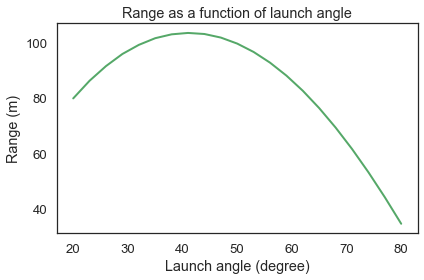

In [11]:
plot(sweep, color='C2')
decorate(xlabel='Launch angle (degree)',
         ylabel='Range (m)',
         title='Range as a function of launch angle',
         legend=False)

savefig('figs/chap23-fig01.pdf')

We can use `maximize` to search for the peak efficiently.

In [12]:
bounds = [0, 90] * degree
res = maximize(range_func, bounds, params)

0 degree 17.15514421874411 meter
90 degree 1.2569667261582053e-14 meter
34.376941012509455 degree 101.06319487191678 meter
55.623058987490545 degree 93.24073676688748 meter
21.246117974981075 degree 82.63917923456437 meter
42.49223594996215 degree 103.32194321543766 meter
47.507764050037856 degree 101.41737997289113 meter
39.39246911258517 degree 103.27504916143039 meter
44.40799721266088 degree 102.90451237123467 meter
41.308230375283905 degree 103.41115569950708 meter
40.576474687263406 degree 103.38512107429113 meter
41.760480261941645 degree 103.4149581469886 meter
42.03998606330441 degree 103.38949811498512 meter
41.58773617664667 degree 103.41463212933446 meter
41.867241978009446 degree 103.41261934653042 meter
41.69449789271447 degree 103.41499899416574 meter
41.65371854587384 degree 103.41492192196334 meter
41.71970091510101 degree 103.41500757170726 meter
41.73527723955511 degree 103.41499793513337 meter
41.710074217168575 degree 103.41500782026304 meter


,values
success,True
x,41.710074217168575 degree
fun,103.41500782026304 meter


`res` is an `ModSimSeries` object with detailed results:

In [13]:
res

,values
success,True
x,41.710074217168575 degree
fun,103.41500782026304 meter


`x` is the optimal angle and `fun` the optional range.

In [14]:
optimal_angle = res.x

41.710074217168575 <Unit('degree')>

In [15]:
max_x_dist = res.fun

103.41500782026304 <Unit('meter')>

### Under the hood

Read the source code for `maximize` and `minimize_scalar`, below.

Add a print statement to `range_func` that prints `angle`.  Then run `maximize` again so you can see how many times it calls `range_func` and what the arguments are.

In [16]:
source_code(maximize)

def maximize_golden(max_func, bracket, *args, **options):
    """Find the maximum of a function by golden section search.

    :param min_func: function to be maximized
    :param bracket: interval containing a maximum
    :param args: arguments passes to min_func
    :param options: rtol and maxiter

    :return: ModSimSeries
    """
    def min_func(*args):
        return -max_func(*args)

    res = minimize_golden(min_func, bracket, *args, **options)

    # we have to negate the function value before returning res
    res.fun = -res.fun
    return res



In [17]:
source_code(minimize_scalar)

def minimize_scalar(min_func, bounds, *args, **options):
    """Finds the input value that minimizes `min_func`.

    Wrapper for
    https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.minimize_scalar.html

    min_func: computes the function to be minimized
    bounds: sequence of two values, lower and upper bounds of the range to be searched
    args: any additional positional arguments are passed to min_func
    options: any keyword arguments are passed as options to minimize_scalar

    returns: ModSimSeries object
    """
    try:
        min_func(bounds[0], *args)
    except Exception as e:
        msg = """Before running scipy.integrate.minimize_scalar, I tried
                 running the slope function you provided with the
                 initial conditions in system and t=0, and I got
                 the following error:"""
        logger.error(msg)
        raise(e)

    underride(options, xatol=1e-3)

    res = scipy.optimize.minimize_scalar(min_func,
   

### The Manny Ramirez problem

Finally, let's solve the Manny Ramirez problem:

*What is the minimum effort required to hit a home run in Fenway Park?*

Fenway Park is a baseball stadium in Boston, Massachusetts.  One of its most famous features is the "Green Monster", which is a wall in left field that is unusually close to home plate, only 310 feet along the left field line.  To compensate for the short distance, the wall is unusually high, at 37 feet.

Although the problem asks for a minimum, it is not an optimization problem.  Rather, we want to solve for the initial velocity that just barely gets the ball to the top of the wall, given that it is launched at the optimal angle.

And we have to be careful about what we mean by "optimal".  For this problem, we don't want the longest range, we want the maximum height at the point where it reaches the wall.

If you are ready to solve the problem on your own, go ahead.  Otherwise I will walk you through the process with an outline and some starter code.

As a first step, write a function called `height_func` that takes a launch angle and a params as parameters, simulates the flights of a baseball, and returns the height of the baseball when it reaches a point 94.5 meters (310 feet) from home plate.

In [18]:
# Solution

def event_func(state, t, system):
    """Stop when the y coordinate is 0.
    
    state: State object
    t: time
    system: System object
    
    returns: y coordinate
    """
    R, V = state
    return R.x - system.x_wall

Always test the slope function with the initial conditions.

In [19]:
# Solution

system = make_system(params)
system.set(x_wall = 94.5 * m)
event_func(system.init, 0, system)

-94.5 <Unit('meter')>

In [20]:
# Solution

def height_func(angle, params):
    """Computes the height of the ball at the wall.
    
    angle: launch angle in degrees
    params: Params object
    
    returns: height in meters
    """
    params = Params(params, angle=angle)
    system = make_system(params)
    system.set(x_wall = 94.5 * m)

    results, details = run_ode_solver(system, slope_func, events=event_func)
    height = get_last_value(results.R).y
    
    return height

Test your function with a launch angle of 45 degrees:

In [21]:
# Solution

height_func(45 * degree, params)

10.953200948514532 <Unit('meter')>

Now use `maximize` to find the optimal angle.  Is it higher or lower than the angle that maximizes range?

In [22]:
# Solution

bounds = [0, 90] * degree
res = maximize(height_func, bounds, params)

,values
success,True
x,44.25082945182002 degree
fun,10.967930469934105 meter


In [23]:
# Solution

optimal_angle = res.x

44.25082945182002 <Unit('degree')>

In [24]:
# Solution

optimal_height = res.fun

10.967930469934105 <Unit('meter')>

With initial velocity 40 m/s and an optimal launch angle, the ball clears the Green Monster with a little room to spare.

Which means we can get over the wall with a lower initial velocity.

### Finding the minimum velocity

Even though we are finding the "minimum" velocity, we are not really solving a minimization problem.  Rather, we want to find the velocity that makes the height at the wall exactly 11 m, given given that it's launched at the optimal angle.  And that's a job for `root_bisect`.

Write an error function that takes a velocity and a `Params` object as parameters.  It should use `maximize` to find the highest possible height of the ball at the wall, for the given velocity.  Then it should return the difference between that optimal height and 11 meters.

In [25]:
# Solution

def error_func(velocity, params):
    """Returns the optimal height at the wall minus the target height.
    
    velocity: initial velocity in m/s
    params: Params object
    
    returns: height difference in meters
    """
    print(velocity)
    params = Params(params, velocity=velocity)
    bounds = [0, 90] * degree
    res = maximize(height_func, bounds, params)
    return res.fun - 11*m

Test your error function before you call `root_bisect`.

In [26]:
# Solution

error_func(40*m/s, params)

40.0 meter / second


-0.03206953006589508 <Unit('meter')>

Then use `root_bisect` to find the answer to the problem, the minimum velocity that gets the ball out of the park.

In [27]:
# Solution

bounds = [30, 50] * m/s
res = root_bisect(error_func, bounds, params, rtol=1e-4)

30.0 meter / second
50.0 meter / second
40.0 meter / second
45.0 meter / second
42.5 meter / second
41.25 meter / second
40.625 meter / second
40.3125 meter / second
40.15625 meter / second
40.078125 meter / second
40.0390625 meter / second
40.01953125 meter / second
40.009765625 meter / second
40.0048828125 meter / second
40.00732421875 meter / second


,values
converged,True
root,40.008544921875 meter / second


In [28]:
# Solution

min_velocity = res.root

40.008544921875 <Unit('meter / second')>

And just to check, run `error_func` with the value you found.

In [29]:
# Solution

error_func(min_velocity, params)

40.008544921875 meter / second


0.002204447936565046 <Unit('meter')>